# Data Analytics final project

*Dominik Woźniak, 2022*

### Dataset

The data was extracted from the 1974 Motor Trend US magazine, and comprises fuel consumption and 10 aspects of automobile design and performance for 32 automobiles (1973--74 models).

https://www.kaggle.com/datasets/ruiromanini/mtcars

In [1]:
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data['y'] = data['mpg']

In [4]:
data.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb,y
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4,21.0
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4,21.0
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1,22.8
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1,21.4
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2,18.7


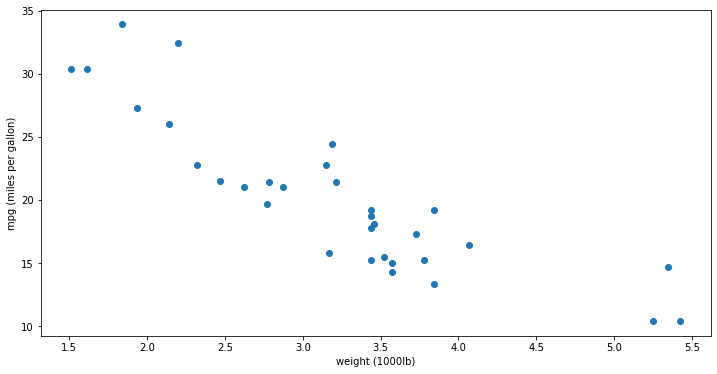

In [5]:
plt.figure(figsize=(12,6))
plt.scatter(data['wt'], data['mpg'])
plt.xlabel('weight (1000lb)')
plt.ylabel('mpg (miles per gallon)')
plt.show()

In [6]:
def plot_trace(param, param_name='parameter'):
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
    
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel('samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
    plt.title('Trace and Posterior Distribution for {}'.format(param_name))

    plt.subplot(2,1,2)
    plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
    plt.xlabel(param_name)
    plt.ylabel('density')
    plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label=r'95\% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
    
    plt.gcf().tight_layout()
    plt.legend()
    
def subplot_trace(ax, param, param_name='parameter', x=0, y=0):
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
    
    ax[x, y].plot(param)
    ax[x, y].axhline(mean, color='r', lw=2, linestyle='--')
    ax[x, y].axhline(median, color='c', lw=2, linestyle='--')
    ax[x, y].axhline(cred_min, linestyle=':', color='k', alpha=0.2)
    ax[x, y].axhline(cred_max, linestyle=':', color='k', alpha=0.2)
    ax[x, y].set_title(param_name)

### Build a Model

In [7]:
from cmdstanpy import CmdStanModel

In [8]:
model = CmdStanModel(stan_file='stan/single_predictor.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [9]:
N = data.shape[0]

model_data = {
    "mpg": data.mpg,
    "weight": data.wt,
    "n": N
}

In [10]:
fit = model.sample(data=model_data)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [11]:
draws = fit.draws_pd()
draws.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta_w,sigma
0,-52.4272,0.891578,0.209095,4.0,19.0,0.0,53.7630,39.2047,-5.63552,3.09327
1,-52.1803,0.888285,0.209095,3.0,11.0,0.0,55.3466,36.7606,-5.45356,3.33965
2,-54.1732,0.832989,0.209095,2.0,7.0,0.0,54.5926,38.2682,-5.19774,3.42444
3,-51.4053,0.942038,0.209095,1.0,3.0,0.0,54.7998,37.7238,-5.44517,3.47197
4,-54.4078,0.942291,0.209095,4.0,15.0,0.0,54.6243,41.9907,-6.60026,2.84778


In [12]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-52.0,0.047,1.40,-55.0,-52.0,-51.0,870.0,2700.0,1.0
alpha,37.0,0.060,2.00,34.0,37.0,40.0,1100.0,3400.0,1.0
beta_w,-5.3,0.018,0.60,-6.3,-5.3,-4.3,1100.0,3400.0,1.0
sigma,3.2,0.012,0.44,2.6,3.1,4.0,1300.0,4000.0,1.0


In [13]:
alpha = draws['alpha']
beta = draws['beta_w']
sigma = draws['sigma']

In [14]:
alpha_mean = draws['alpha'].mean()
beta_mean = draws['beta_w'].mean()
sigma_mean = draws['sigma'].mean()

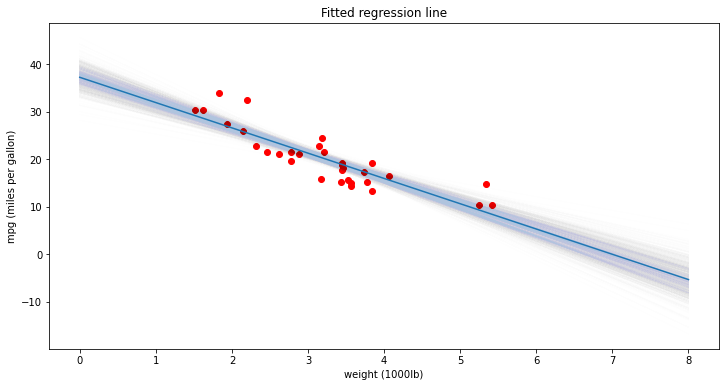

In [15]:
def show_regression(alpha, beta, alpha_mean, beta_mean):
    x_min, x_max = 0, 8
    x_plot = np.linspace(x_min, x_max, 100)

    plt.figure(figsize=(12,6))
    for i in np.random.randint(0, len(alpha), 1000):
        plt.plot(x_plot, alpha[i] + beta[i] * x_plot, color='lightsteelblue', alpha=0.005)

    plt.plot(x_plot, alpha_mean + beta_mean * x_plot)
    plt.scatter(data['wt'], data['mpg'], color='r')
    plt.xlabel('weight (1000lb)')
    plt.ylabel('mpg (miles per gallon)')
    plt.title('Fitted regression line')
    plt.show()
    
show_regression(alpha, beta, alpha_mean, beta_mean)

- Alpha for a car with a weight of 0, the expected mpg is 37.37. Weight of zero is impossible. It will be limited in the next model.
Comparing two cars who differ by 1000 pounds, the model predicts a difference of 5.4 miles per gallon.

- The first change that can be made to the model is center our weight variable so that we can get a more meaningful interpretation of the intercept parameter alpha. We can accomplish this by subtracting the mean from each observation. This will change the interpretation of the intercept to be the average MPG when weight is held constant at it’s average value.

- The model predicts miles per gallon to be 3.2.

- `lp__` - logarithm of the posterior density. This parameter can be used in various ways for model evaluation and comparison.

**Center weight:**

In [16]:
data['wt_center'] = data['wt'] - data['wt'].mean()

In [17]:
data.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb,y,wt_center
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4,21.0,-0.59725
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4,21.0,-0.34225
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1,22.8,-0.89725
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1,21.4,-0.00225
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2,18.7,0.22275


In [18]:
model = CmdStanModel(stan_file='stan/single_predictor_center.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [19]:
N = data.shape[0]

model_data = {
    "mpg": data.mpg,
    "weight_center": data.wt_center,
    "n": N
}

In [20]:
fit = model.sample(data=model_data)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [21]:
draws = fit.draws_pd()
draws.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta_w,sigma
0,-50.4710,0.920801,0.666461,2.0,7.0,0.0,51.2137,20.3443,-4.77298,3.39272
1,-50.1972,0.999663,0.666461,3.0,7.0,0.0,50.6969,20.2106,-4.72559,3.16170
2,-50.7032,0.870519,0.666461,3.0,7.0,0.0,53.4723,20.4688,-5.98002,2.80930
3,-50.9968,0.981540,0.666461,2.0,3.0,0.0,51.1061,20.4914,-6.03101,2.75978
4,-52.2122,0.816194,0.666461,2.0,3.0,0.0,54.0006,20.0074,-6.56261,2.88934


In [22]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-51.0,0.0280,1.20,-53.0,-51.0,-50.0,2000.0,15000.0,1.0
alpha,20.0,0.0100,0.56,19.0,20.0,21.0,3100.0,24000.0,1.0
beta_w,-5.4,0.0093,0.59,-6.4,-5.4,-4.4,4000.0,31000.0,1.0
sigma,3.2,0.0072,0.42,2.6,3.1,3.9,3400.0,26000.0,1.0


- The model predicts miles per gallon to be 3.2 -  the same as before.

- `lp__` has lower value  than the previous model. It mean that this model performs slightly better.

**Multiparameter:**

In [23]:
data['hp_center'] = data['hp'] - data['hp'].mean()
data['cyl_center'] = data['cyl'] - data['cyl'].mean()

In [24]:
data.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb,y,wt_center,hp_center,cyl_center
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4,21.0,-0.59725,-36.6875,-0.1875
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4,21.0,-0.34225,-36.6875,-0.1875
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1,22.8,-0.89725,-53.6875,-2.1875
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1,21.4,-0.00225,-36.6875,-0.1875
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2,18.7,0.22275,28.3125,1.8125


In [25]:
model = CmdStanModel(stan_file='stan/multiparameters_predictor.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [26]:
N = data.shape[0]

model_data = {
    "mpg": data.mpg,
    "weight_center": data.wt_center,
    "hp_center": data.hp_center,
    "cylinders_center": data.cyl_center,
    "n": N
}

In [27]:
fit = model.sample(data=model_data)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [28]:
draws = fit.draws_pd()
draws.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta_w,beta_cyl,beta_hp,sigma
0,-49.1838,0.871348,0.297851,3.0,7.0,0.0,51.6685,20.3767,-4.55136,-0.258728,-0.013828,1.85686
1,-44.1322,1.000000,0.297851,3.0,7.0,0.0,51.8687,20.5437,-2.40073,-1.126880,-0.024236,2.23474
2,-44.4508,0.853772,0.297851,4.0,15.0,0.0,46.8435,20.6703,-3.90601,-0.550342,-0.015932,2.82065
3,-44.7102,0.964045,0.297851,4.0,15.0,0.0,46.5006,19.3441,-2.57767,-1.034040,-0.016125,2.46773
4,-43.0006,0.927949,0.297851,3.0,15.0,0.0,47.2207,19.8897,-2.84703,-1.061570,-0.013987,2.31533


In [29]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-45.000,0.04500,1.700,-49.000,-45.000,-43.000,1500.0,4900.0,1.0
alpha,20.000,0.00720,0.450,19.000,20.000,21.000,3900.0,13000.0,1.0
beta_w,-3.200,0.01400,0.780,-4.400,-3.200,-1.900,3000.0,9900.0,1.0
beta_cyl,-0.950,0.01100,0.580,-1.900,-0.950,0.016,2800.0,9500.0,1.0
beta_hp,-0.018,0.00022,0.013,-0.038,-0.018,0.003,3200.0,11000.0,1.0
sigma,2.600,0.00680,0.370,2.100,2.600,3.300,3000.0,9900.0,1.0


- Using Car’s cylinders and horsepower data helps, `lp__` for current model is lower than earlier models.

- the model predicts 2.6 miles per gallon.

In [30]:
lp = draws['lp__']
alpha = draws['alpha']
beta_w = draws['beta_w']
beta_cyl = draws['beta_cyl']
beta_hp = draws['beta_hp']
sigma = draws['sigma']

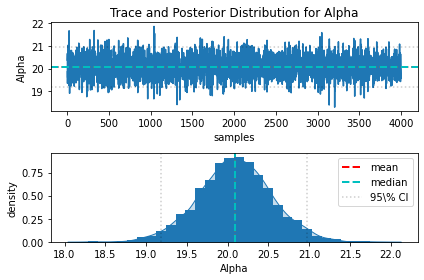

In [31]:
plot_trace(alpha, 'Alpha')

In [32]:
# TODO: interpratate (?)

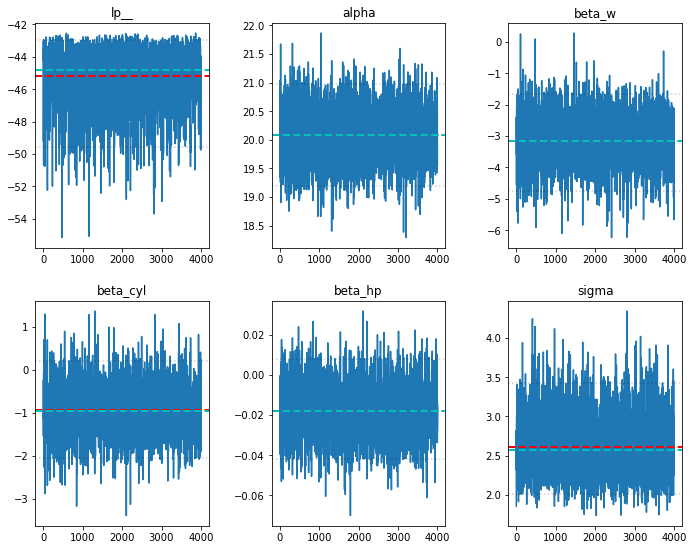

In [33]:
fig, axs = plt.subplots(2, 3, figsize=(10, 8))

subplot_trace(axs, lp, 'lp__', 0, 0)
subplot_trace(axs, alpha, 'alpha', 0, 1)
subplot_trace(axs, beta_w, 'beta_w', 0, 2)
subplot_trace(axs, beta_cyl, 'beta_cyl', 1, 0)
subplot_trace(axs, beta_hp, 'beta_hp', 1, 1)
subplot_trace(axs, sigma, 'sigma', 1, 2)

fig.tight_layout(pad=2.0)
plt.show()

 - we want to check that our chains have converged and are producing reliable point estimates. We can see that the movement through parameter space resembles a random walk, which is indicative that the underlying Markov chain has reached convergence as we would hope.
 
 - the chains are mixing well and have converged to a common distribution.

<AxesSubplot:title={'center':'alpha'}>

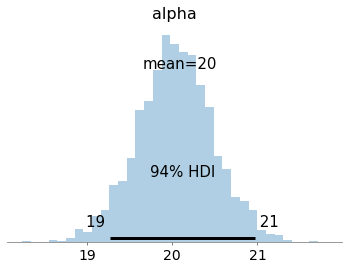

In [34]:
az.plot_posterior(fit, var_names=['alpha'], round_to=2, kind='hist', bins=35)

**Posterior predictive**

`normal_rng` is the Stan function to generate observations from a normal distribution. So, `y_rep` generates new data points from a normal distribution using the linear model we built `mu` and a variance `sigma`.

In [35]:
model_data = {
    "mpg": data['mpg'],
    "weight_center": data.wt_center,
    "hp_center": data.hp_center,
    "cylinders_center": data.cyl_center,
    "n": N
}

In [36]:
model = CmdStanModel(stan_file='stan/posterior_predictive.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [37]:
fit = model.sample(data=model_data)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [38]:
fit.summary().head(10)

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-45.000,0.04300,1.600,-48.000,-45.000,-43.0000,1500.0,3900.0,1.0
alpha,20.000,0.00740,0.470,19.000,20.000,21.0000,4000.0,10000.0,1.0
beta_w,-3.200,0.01300,0.770,-4.400,-3.200,-1.9000,3400.0,8800.0,1.0
beta_cyl,-0.930,0.01200,0.600,-1.900,-0.940,0.0520,2500.0,6500.0,1.0
beta_hp,-0.018,0.00023,0.013,-0.038,-0.018,0.0023,3000.0,7900.0,1.0
sigma,2.600,0.00740,0.370,2.100,2.600,3.3000,2500.0,6500.0,1.0
y_rep[1],23.000,0.04500,2.800,18.000,23.000,27.0000,3757.0,9860.0,1.0
y_rep[2],22.000,0.04300,2.700,18.000,22.000,27.0000,4034.0,10587.0,1.0
y_rep[3],26.000,0.04500,2.800,21.000,26.000,31.0000,3823.0,10033.0,1.0


In [39]:
draws = fit.draws_pd()
draws.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta_w,beta_cyl,...,y_rep[23],y_rep[24],y_rep[25],y_rep[26],y_rep[27],y_rep[28],y_rep[29],y_rep[30],y_rep[31],y_rep[32]
0,-45.1072,0.955317,0.310936,4.0,15.0,0.0,46.7328,20.1747,-4.38737,-0.121446,...,17.6452,12.5828,15.0805,28.9407,26.4760,32.6246,15.5394,16.8315,14.64200,23.9084
1,-45.0343,0.987911,0.310936,3.0,7.0,0.0,45.8465,20.0753,-3.98526,0.154363,...,20.2767,14.4314,16.1743,29.0013,25.5352,27.0284,15.8338,21.8419,10.84810,23.7996
2,-46.2244,0.982580,0.310936,4.0,15.0,0.0,48.7286,21.1432,-3.61220,-0.595749,...,15.5903,13.4732,18.2710,30.5952,31.6646,28.1620,16.1196,21.7892,9.36089,24.6607
3,-46.4828,0.997917,0.310936,3.0,7.0,0.0,47.7050,21.3066,-3.50481,-0.647242,...,18.8885,14.4413,17.9034,29.5893,30.9958,29.5202,20.5755,20.7197,14.32730,26.8246
4,-48.9702,0.953387,0.310936,3.0,7.0,0.0,50.0746,21.5984,-3.93321,-0.066739,...,17.1239,11.4517,18.5461,28.1959,26.5768,21.5783,14.3889,23.7169,17.26210,29.9344


In [40]:
y_pred = fit.stan_variable('y_rep')

array([[<AxesSubplot:title={'center':'y_rep'}>,
        <AxesSubplot:title={'center':'y_rep'}>]], dtype=object)

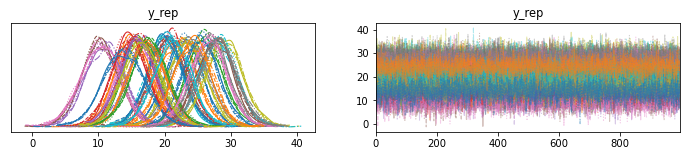

In [41]:
az.plot_trace(fit, var_names=['y_rep'])

In [42]:
idata = az.from_cmdstanpy(
    posterior=fit,
    posterior_predictive=["y_rep"], 
    observed_data={"mpg": data['mpg']},
)

<AxesSubplot:xlabel='mpg / y_rep'>

/Users/dominikwozniak/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


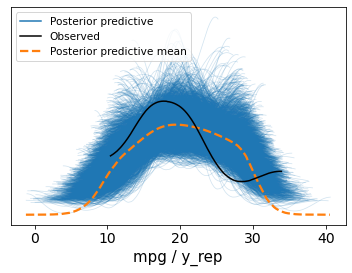

In [43]:
az.plot_ppc(idata, data_pairs={"mpg": "y_rep"})

The closer the replicated values - `y_rep` - get to the observed values (`y`) the more accurate the model. The model could be probably do a bit better, Maybe is likely due to the small size of data - which adds more uncertainty.


**Better priors model**

To improve model we can use more imfornamtive priors. Priors allows us to use background knowledge to use in the model. We will obtain more realistic estimates as a result.

We didn't use priors in the previous model. It used flat priors by default - it place all possible coefficient values an equal probably. This scenario is not very realistic.

In [44]:
model_data = {
    "mpg": data['mpg'],
    "weight_center": data.wt_center,
    "hp_center": data.hp_center,
    "cylinders_center": data.cyl_center,
    "n": N
}

In [45]:
model = CmdStanModel(stan_file='stan/prior_model.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [46]:
fit_prior = model.sample(data=model_data)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [47]:
fit_prior.summary().head(10)

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-46.000,0.04700,1.700,-49.000,-46.000,-44.0000,1400.0,3400.0,1.0
alpha,20.000,0.00730,0.470,19.000,20.000,21.0000,4200.0,11000.0,1.0
beta_w,-3.300,0.01700,0.790,-4.700,-3.300,-2.1000,2200.0,5600.0,1.0
beta_cyl,-0.850,0.01500,0.570,-1.800,-0.860,0.0860,1400.0,3600.0,1.0
beta_hp,-0.018,0.00029,0.012,-0.039,-0.018,0.0017,1800.0,4600.0,1.0
sigma,2.600,0.00750,0.370,2.100,2.600,3.3000,2400.0,6100.0,1.0
y_rep[1],23.000,0.04500,2.800,18.000,23.000,28.0000,3778.0,9468.0,1.0
y_rep[2],22.000,0.04600,2.800,17.000,22.000,26.0000,3602.0,9028.0,1.0
y_rep[3],26.000,0.04500,2.800,21.000,26.000,30.0000,3802.0,9528.0,1.0


The model with more informative priors have a bit lower `lp__` than the previous model.

In [48]:
draws = fit_prior.draws_pd()
draws.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta_w,beta_cyl,...,y_rep[23],y_rep[24],y_rep[25],y_rep[26],y_rep[27],y_rep[28],y_rep[29],y_rep[30],y_rep[31],y_rep[32]
0,-50.5829,0.622421,0.310547,3.0,7.0,0.0,51.7428,19.9836,-4.46536,-1.878990,...,16.7008,7.53040,13.1809,26.3198,26.7664,32.9322,17.0241,23.8081,19.6779,28.4227
1,-44.2840,0.964686,0.310547,3.0,11.0,0.0,51.9615,20.4156,-3.55540,-0.805286,...,19.2945,8.60533,12.2655,30.1652,27.9333,25.8166,15.3793,25.7315,15.0009,26.2081
2,-45.4713,0.953983,0.310547,3.0,15.0,0.0,46.7267,20.2016,-3.73302,-0.969219,...,15.9385,15.27290,15.4380,29.7596,25.4297,32.0788,19.1430,20.5969,12.2577,21.6003
3,-47.8490,0.947998,0.310547,4.0,15.0,0.0,50.0795,21.0898,-3.61717,-1.515490,...,13.8333,17.15490,15.8431,35.8096,31.7510,35.3149,18.6667,25.5157,17.5394,26.6723
4,-49.8222,0.992084,0.310547,4.0,15.0,0.0,52.0475,18.9551,-5.04822,-0.077209,...,16.4101,15.11640,12.9280,24.6224,22.5722,24.7882,15.9135,23.0579,17.0259,18.4824


In [49]:
beta_w = draws['beta_w']

<AxesSubplot:>

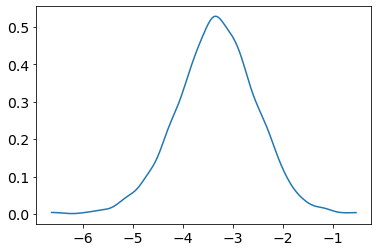

In [50]:
az.plot_dist(beta_w)

<AxesSubplot:title={'center':'beta_w'}>

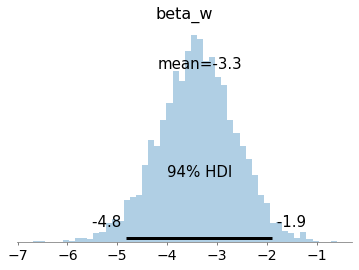

In [51]:
az.plot_posterior(fit_prior, var_names=['beta_w'], round_to=2, kind='hist', bins=50)

In [52]:
idata = az.from_cmdstanpy(
    posterior=fit_prior,
    posterior_predictive=["y_rep"], 
    observed_data={"mpg": data['mpg']},
)

<AxesSubplot:xlabel='mpg / y_rep'>

/Users/dominikwozniak/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


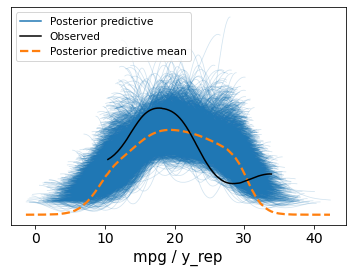

In [53]:
az.plot_ppc(idata, data_pairs={"mpg": "y_rep"})

In [54]:
lp = draws['lp__']
alpha = draws['alpha']
beta = draws['beta_w']
beta_cyl = draws['beta_cyl']
beta_hp = draws['beta_hp']
sigma = draws['sigma']

alpha_mean = alpha.mean()
beta_mean = beta_w.mean()

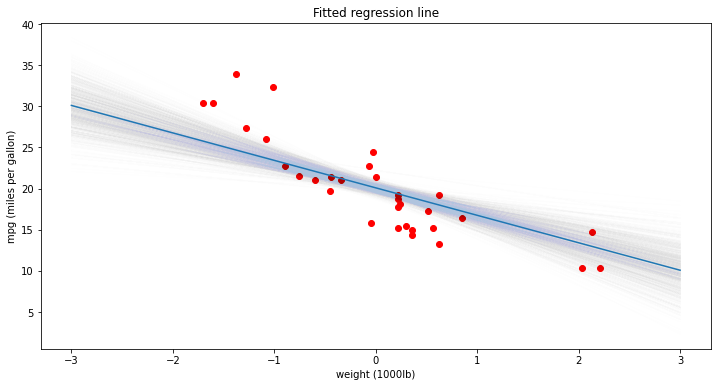

In [55]:
def show_regression(alpha, beta, alpha_mean, beta_mean):
    x_min, x_max = -3, 3
    x_plot = np.linspace(x_min, x_max, 100)

    plt.figure(figsize=(12,6))
    for i in np.random.randint(0, len(alpha), 1000):
        plt.plot(x_plot, alpha[i] + beta[i] * x_plot, color='lightsteelblue', alpha=0.005)

    plt.plot(x_plot, alpha_mean + beta_mean * x_plot)
    plt.scatter(data['wt_center'], data['mpg'], color='r')
    plt.xlabel('weight (1000lb)')
    plt.ylabel('mpg (miles per gallon)')
    plt.title('Fitted regression line')
    plt.show()
    
show_regression(alpha, beta, alpha_mean, beta_mean)

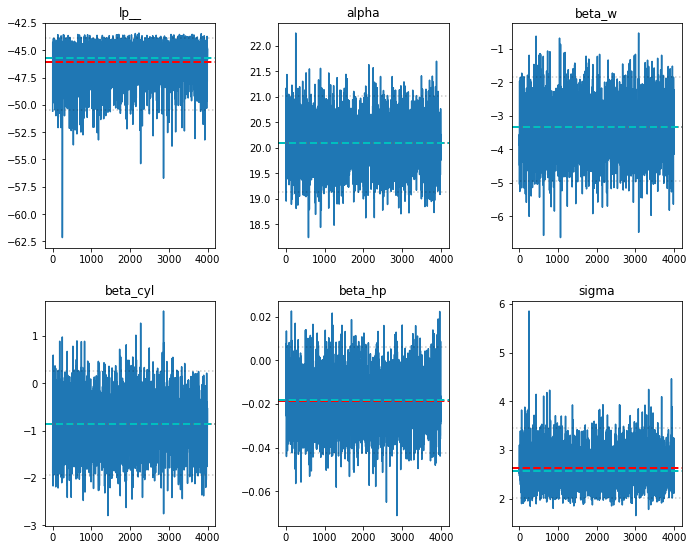

In [56]:
fig, axs = plt.subplots(2, 3, figsize=(10, 8))

subplot_trace(axs, lp, 'lp__', 0, 0)
subplot_trace(axs, alpha, 'alpha', 0, 1)
subplot_trace(axs, beta_w, 'beta_w', 0, 2)
subplot_trace(axs, beta_cyl, 'beta_cyl', 1, 0)
subplot_trace(axs, beta_hp, 'beta_hp', 1, 1)
subplot_trace(axs, sigma, 'sigma', 1, 2)

fig.tight_layout(pad=2.0)
plt.show()

In [57]:
# TODO: fix comparing models

# fit_1 = az.from_cmdstanpy(
#     posterior=fit,
#     posterior_predictive=["y_rep"], 
#     observed_data={"mpg": data['mpg']},
# )

# fit_2 = az.from_cmdstanpy(
#     posterior=fit_prior,
#     posterior_predictive=["y_rep"], 
#     observed_data={"mpg": data['mpg']},
# )

# model_compare = az.compare(dataset_dict ={'First':fit_1,'Second':fit_2})

TypeError: Encountered error trying to compute loo from model First.

In [58]:
# TODO: add Coeficient Plot